In [11]:
import numpy as np
import torch
import torch_geometric
from torch_cluster import knn, knn_graph
import open3d as o3d
#utils
import h5py
import os
import dataclasses

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss


## Utils

### Load data

In [2]:
def load_h5_data(h5_filename='', opts=None, skip_rate = 1, use_randominput=True):
    """
    skip_rate: {int} -- step_size when loading the dataset
    """
    num_point = opts.num_point
    num_4X_point = int(opts.num_point*4)
    num_out_point = int(opts.num_point*opts.up_ratio)

    print("h5_filename : ",h5_filename)
    if use_randominput:
        print("use randominput, input h5 file is:", h5_filename)
        f = h5py.File(h5_filename)
        input = f['poisson_%d'%num_4X_point][:]
        gt = f['poisson_%d'%num_out_point][:]
    else:
        print("Do not randominput, input h5 file is:", h5_filename)
        f = h5py.File(h5_filename)
        input = f['poisson_%d' % num_point][:]
        gt = f['poisson_%d' % num_out_point][:]

    #name = f['name'][:]
    assert len(input) == len(gt)

    print("Normalization the data")
    data_radius = np.ones(shape=(len(input)))
    centroid = np.mean(gt[:, :, 0:3], axis=1, keepdims=True)
    gt[:, :, 0:3] = gt[:, :, 0:3] - centroid
    furthest_distance = np.amax(np.sqrt(np.sum(gt[:, :, 0:3] ** 2, axis=-1)), axis=1, keepdims=True)
    gt[:, :, 0:3] = gt[:, :, 0:3] / np.expand_dims(furthest_distance, axis=-1)
    input[:, :, 0:3] = input[:, :, 0:3] - centroid
    input[:, :, 0:3] = input[:, :, 0:3] / np.expand_dims(furthest_distance, axis=-1)

    input = input[::skip_rate]
    gt = gt[::skip_rate]
    data_radius = data_radius[::skip_rate]
    print("total %d samples" % (len(input)))
    return input, gt, data_radius

### Viz

In [3]:
def viz_pcd_graph(points, edge_list):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(p)
    ls = o3d.geometry.LineSet.create_from_point_cloud_correspondences(pcd, pcd, edge_list)
    ls.paint_uniform_color([0.5, 0.5, 0.5])
    o3d.visualization.draw_geometries([pcd, ls])
    
def viz_many(clouds: list):
    pcds = []
    for i, p in enumerate(clouds):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(p + i * np.array([3, 0, 0])) # shift to see them side by side
        pcds.append(pcd)
    o3d.visualization.draw_geometries(pcds)
    
def viz_many_mpl(clouds: list[np.ndarray], d = 3, ax = None):
    points = None
    for i, p in enumerate(clouds):

        points = p if points is None else np.concatenate([points, p + i * np.array([d, 0, 0])])

    if ax is None:
        fig = plt.figure()
        ax = plt.axes(projection='3d')

    ax.scatter(*points.T)

    plt.show()


### Configs

In [4]:
@dataclasses.dataclass
class ModelConfig:
    num_point: int = 256 # number of points per sample
    up_ratio: int = 4 # upsampling ratio
    dilation: int = 2 # dilation in DenseGCN 
    num_neighbours: int = 20 # num neighbours in DenseGCN 
    n_idgcn_blocks: int = 2 # number of inception dense blocks
    channels: int = 32 # number of channels for gcn
    n_dgcn_blocks: int = 3 # number of DenseGCNBlocks in the DenseGCN
    
    
@dataclasses.dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 10
    optimizer = "adam"
    lr = .001
    beta = .9
    

opts = ModelConfig()
train_config = TrainConfig()

### Losses

In [10]:
def chamfer_distance(p: torch.Tensor, q: torch.Tensor):
    """
        p, q: arrays of shape (num_points, num_dim)
    """
    
    closest_to_q = p[knn(p, q, 1)[1]]  # points in p closest to each point in q
    closest_to_p = q[knn(q, p, 1)[1]] # points in q closest to each point in p
    
    e1 = (p - closest_to_p).pow(2).sum(-1)
    e2 = (q - closest_to_q).pow(2).sum(-1)
    cd = e1.mean() + e2.mean()
    return cd

# Data

In [5]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
class PCDDataset(Dataset):
    def __init__(self, data_path, opts, skip_rate = 1):
        f = h5py.File(data_path, 'r')
        data, ground_truth, data_radius = load_h5_data(h5_filename=data_path, opts=opts, skip_rate = skip_rate, use_randominput=False)
        self.data = torch.tensor(data)
        self.ground_truth = torch.tensor(ground_truth)

    def __getitem__(self, idx):
        return self.data[idx], self.ground_truth[idx]

        
    def __len__(self):
        return len(self.data)
    

In [8]:
dataset = PCDDataset(data_path, opts, 5)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 13800 samples


In [9]:
data_cloud, gt_cloud = next(iter(dataset))

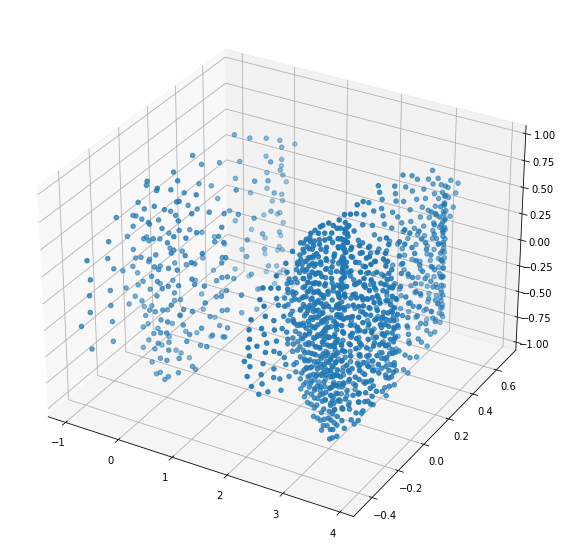

In [12]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([data_cloud, gt_cloud], ax = ax)

# Training

## Train one point cloud at a time

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from pugcn_lib import PUGCN

In [15]:
dataset = PCDDataset(data_path, opts, 10)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 6900 samples


In [16]:
train_perc = .8
trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)])

In [17]:
trainloader = DataLoader(trainset, batch_size=64)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [28]:
pugcn = PUGCN(opts).to(device)

loss_fn = loss_fn = ChamferLoss()
optimizer = torch.optim.Adam(params = pugcn.parameters(), lr = train_config.lr)

In [29]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

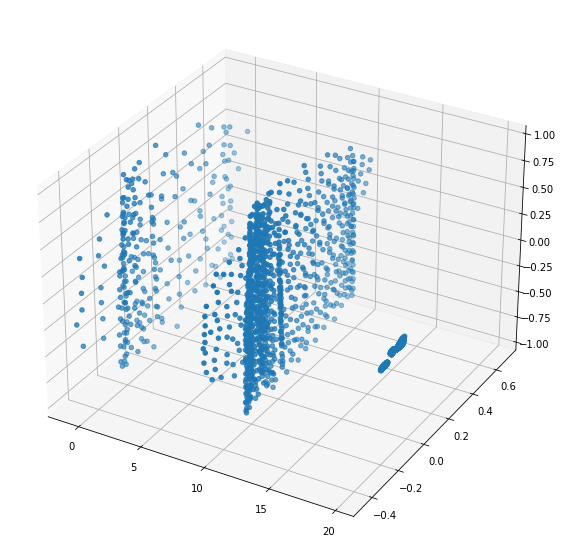

In [30]:
pred = pugcn(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

viz_many_mpl([data_cloud, gt_cloud, pred], d = 10, ax = ax)

In [31]:
def train(model, trainset, loss_fn, optimizer):
    
    total_loss = 0.
    for p, q in (t:= tqdm(trainset)):
        p, q = p.to(device), q.to(device)
        optimizer.zero_grad()
        
        pred = model(p)
        d1, d2, _, _ = loss_fn(pred.unsqueeze(0), q.unsqueeze(0))
        loss = d1.mean() + d2.mean()
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss
    

In [32]:
l = train(pugcn, trainset, loss_fn, optimizer)

  0%|          | 0/5520 [00:00<?, ?it/s]

In [ ]:
idx = 0 
sample, gt = trainset[idx]

In [94]:
idx = np.random.choice(len(valset)) # 0 
sample, gt = valset[idx]

In [95]:
pred = pugcn(sample.to(device)).cpu().detach().numpy()
pred

array([[ 4.6057139e-02,  7.7778652e-02, -2.7102086e-01],
       [ 4.3975696e-02, -2.4105743e-02,  1.3889344e-01],
       [ 3.1719446e-02,  4.7255307e-04,  1.2990589e-01],
       ...,
       [-2.1432725e-01,  3.4000722e-01, -5.0823640e-02],
       [-1.9326282e-01,  1.3376692e-01,  4.0646724e-02],
       [ 4.6600479e-01, -7.1326321e-01,  3.0012466e-03]], dtype=float32)

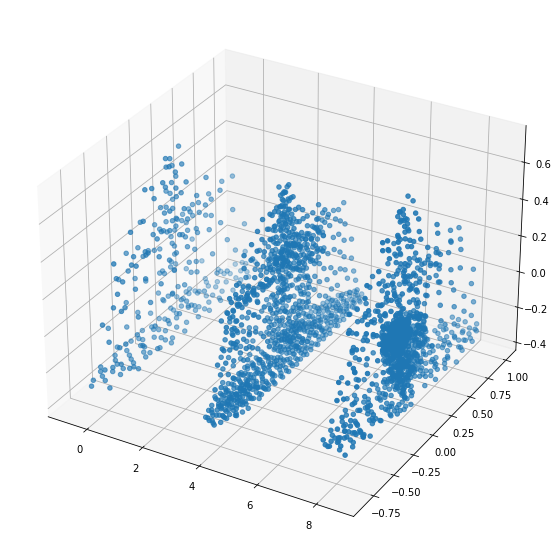

In [96]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([sample, gt, pred], d = 4, ax = ax)